In [1]:
from torch_snippets import *
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from xml.etree import ElementTree as et
device = 'cuda' if torch.cuda.is_available() else 'cpu'

You should consider upgrading via the '/Users/matvejzasadko/.pyenv/versions/3.8.13/bin/python3.8 -m pip install --upgrade pip' command.


In [5]:
root = '/Users/matvejzasadko/Downloads/All/Study/NNetworks/Lb1/archive/train_zip/train'

labels = ['orange', 'apple', 'banana']
label2targets = {l: t for t, l in enumerate(labels)}
targets2label = {t: l for l, t in label2targets.items()}
num_classes = len(targets2label)

In [6]:
def preprocess_img(img):
    img = torch.tensor(img).permute(2, 0 ,1)
    return img.to(device).float()


In [7]:
class FruitsDataset(Dataset):
    def __init__(self, root=root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.img_paths = sorted(Glob(self.root + '/*.jpg'))
        self.xlm_paths = sorted(Glob(self.root + '/*.xml'))
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        w, h = 224, 224
        img_path = self.img_paths[idx]
        xlm_path = self.xlm_paths[idx]
        img = Image.open(img_path).convert('RGB')
        W, H = img.size
        img = np.array(img.resize((w, h), 
                       resample=Image.Resampling.BILINEAR))/255.
        xlm = et.parse(xlm_path)
        objects = xlm.findall('object')
        labels = []
        boxes = []
        for obj in objects:
            label = obj.find('name').text
            labels.append(label)
            XMin = float(obj.find('bndbox').find('xmin').text)
            YMin = float(obj.find('bndbox').find('ymin').text)
            XMax = float(obj.find('bndbox').find('xmax').text)
            YMax = float(obj.find('bndbox').find('ymax').text)
            bbox = [XMin / W, YMin / H, XMax / W, YMax / H]
            bbox = (bbox * np.array([w, h, w, h])).astype(np.int16).tolist()
            boxes.append(bbox)
            target = {}
            
        target['labels'] = torch.tensor([label2targets[label] for label in labels]).long()
        target['boxes'] = torch.tensor(boxes).float()
        img = preprocess_img(img)
        return img, target
    
    def collate_fn(self, batch):
        return tuple(zip(*batch))

val_root = '/Users/matvejzasadko/Downloads/All/Study/NNetworks/Lb1/archive/test_zip/test'
    
tr_ds = FruitsDataset()
tr_dl = DataLoader(tr_ds, batch_size=4, shuffle=True, collate_fn=tr_ds.collate_fn)

val_ds = FruitsDataset(root=val_root)
val_dl = DataLoader(val_ds, batch_size=2, shuffle=True, collate_fn=val_ds.collate_fn)

img, target = tr_ds[10]

In [8]:
def get_model():
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

imgs, targets = next(iter(tr_dl))
imgs = list(img.to(device) for img in imgs)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model = get_model().to(device)
model(imgs, targets)

/Users/matvejzasadko/.pyenv/versions/3.8.13/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/matvejzasadko/.pyenv/versions/3.8.13/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


{'loss_classifier': tensor(0.9357, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0771, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0015, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0025, grad_fn=<DivBackward0>)}

In [9]:
def train_batch(batch, model, optim):
    model.train()
    imgs, targets = batch
    imgs = list(img.to(device) for img in imgs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optim.zero_grad()
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optim.step()
    return loss, losses

In [10]:
@torch.no_grad()
def validate_batch(batch, model, optim):
    model.train()
    imgs, targets = batch
    imgs = list(img.to(device) for img in imgs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optim.zero_grad()
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

model = get_model().to(device)
optim = torch.optim.SGD(model.parameters(), lr=0.005,
                       weight_decay=5e-4, momentum=0.9)

In [16]:
n_epochs = 5

In [17]:
for e in range(n_epochs):
    for i, batch in enumerate(tr_dl):
        N = len(tr_dl)
        loss, losses = train_batch(batch, model, optim)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in 
                                                                  ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        print("Epoch: ", e)
        print("Train Class loss: ", loc_loss)
        print("Train BBox loss: ", regr_loss)
        print(" ")
    
    for i, batch in enumerate(val_dl):
        N = len(val_dl)
        loss, losses = validate_batch(batch, model.float(), optim)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in 
                                                                  ['loss_classifier', 'loss_box_reg', 
                                                                   'loss_objectness', 'loss_rpn_box_reg']]
        print("Epoch: ", e)
        print("Validation Class loss: ", loc_loss)
        print("Validation BBox loss: ", regr_loss)
        print(" ")

Epoch:  0
Train Class loss:  tensor(0.0272, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.0760, grad_fn=<DivBackward0>)
 
Epoch:  0
Train Class loss:  tensor(0.0113, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.0221, grad_fn=<DivBackward0>)
 
Epoch:  0
Train Class loss:  tensor(0.0084, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.0068, grad_fn=<DivBackward0>)
 
Epoch:  0
Train Class loss:  tensor(0.0258, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.0736, grad_fn=<DivBackward0>)
 
Epoch:  0
Train Class loss:  tensor(0.0628, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.1936, grad_fn=<DivBackward0>)
 
Epoch:  0
Train Class loss:  tensor(0.0216, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.0490, grad_fn=<DivBackward0>)
 
Epoch:  0
Train Class loss:  tensor(0.0083, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.0303, grad_fn=<DivBackward0>)
 
Epoch:  0
Train Class loss:  tensor(0.0505, grad_fn=<NllLossBackward0>)
Train BBox 

Epoch:  0
Validation Class loss:  tensor(0.0584)
Validation BBox loss:  tensor(0.2114)
 
Epoch:  0
Validation Class loss:  tensor(0.1202)
Validation BBox loss:  tensor(0.2122)
 
Epoch:  0
Validation Class loss:  tensor(0.0518)
Validation BBox loss:  tensor(0.1283)
 
Epoch:  0
Validation Class loss:  tensor(0.0102)
Validation BBox loss:  tensor(0.0312)
 
Epoch:  0
Validation Class loss:  tensor(0.0060)
Validation BBox loss:  tensor(0.0195)
 
Epoch:  0
Validation Class loss:  tensor(0.0116)
Validation BBox loss:  tensor(0.0224)
 
Epoch:  0
Validation Class loss:  tensor(0.0507)
Validation BBox loss:  tensor(0.0615)
 
Epoch:  0
Validation Class loss:  tensor(0.0139)
Validation BBox loss:  tensor(0.0584)
 
Epoch:  0
Validation Class loss:  tensor(0.0901)
Validation BBox loss:  tensor(0.1659)
 
Epoch:  0
Validation Class loss:  tensor(0.0638)
Validation BBox loss:  tensor(0.1053)
 
Epoch:  0
Validation Class loss:  tensor(0.0259)
Validation BBox loss:  tensor(0.0693)
 
Epoch:  0
Validation 

Epoch:  1
Train Class loss:  tensor(0.0053, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.0095, grad_fn=<DivBackward0>)
 
Epoch:  1
Train Class loss:  tensor(0.0438, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.1393, grad_fn=<DivBackward0>)
 
Epoch:  1
Train Class loss:  tensor(0.0242, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.0658, grad_fn=<DivBackward0>)
 
Epoch:  1
Train Class loss:  tensor(0.0091, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.0141, grad_fn=<DivBackward0>)
 
Epoch:  1
Train Class loss:  tensor(0.0376, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.1131, grad_fn=<DivBackward0>)
 
Epoch:  1
Train Class loss:  tensor(0.0159, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.0371, grad_fn=<DivBackward0>)
 
Epoch:  1
Train Class loss:  tensor(0.0566, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.1638, grad_fn=<DivBackward0>)
 
Epoch:  1
Train Class loss:  tensor(0.0169, grad_fn=<NllLossBackward0>)
Train BBox 

Epoch:  2
Train Class loss:  tensor(0.0355, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.0759, grad_fn=<DivBackward0>)
 
Epoch:  2
Train Class loss:  tensor(0.0220, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.0500, grad_fn=<DivBackward0>)
 
Epoch:  2
Train Class loss:  tensor(0.0065, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.0183, grad_fn=<DivBackward0>)
 
Epoch:  2
Train Class loss:  tensor(0.0274, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.0985, grad_fn=<DivBackward0>)
 
Epoch:  2
Train Class loss:  tensor(0.0102, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.0185, grad_fn=<DivBackward0>)
 
Epoch:  2
Train Class loss:  tensor(0.0496, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.1002, grad_fn=<DivBackward0>)
 
Epoch:  2
Train Class loss:  tensor(0.0319, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.0973, grad_fn=<DivBackward0>)
 
Epoch:  2
Train Class loss:  tensor(0.0162, grad_fn=<NllLossBackward0>)
Train BBox 

Epoch:  3
Train Class loss:  tensor(0.0364, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.0676, grad_fn=<DivBackward0>)
 
Epoch:  3
Train Class loss:  tensor(0.0111, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.0185, grad_fn=<DivBackward0>)
 
Epoch:  3
Train Class loss:  tensor(0.0362, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.0834, grad_fn=<DivBackward0>)
 
Epoch:  3
Train Class loss:  tensor(0.0102, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.0180, grad_fn=<DivBackward0>)
 
Epoch:  3
Train Class loss:  tensor(0.0065, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.0084, grad_fn=<DivBackward0>)
 
Epoch:  3
Train Class loss:  tensor(0.0193, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.0544, grad_fn=<DivBackward0>)
 
Epoch:  3
Train Class loss:  tensor(0.0402, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.1119, grad_fn=<DivBackward0>)
 
Epoch:  3
Train Class loss:  tensor(0.0140, grad_fn=<NllLossBackward0>)
Train BBox 

Epoch:  3
Validation Class loss:  tensor(0.0110)
Validation BBox loss:  tensor(0.0387)
 
Epoch:  3
Validation Class loss:  tensor(0.0041)
Validation BBox loss:  tensor(0.0099)
 
Epoch:  3
Validation Class loss:  tensor(0.0281)
Validation BBox loss:  tensor(0.0622)
 
Epoch:  3
Validation Class loss:  tensor(0.0929)
Validation BBox loss:  tensor(0.1999)
 
Epoch:  3
Validation Class loss:  tensor(8.2549e-05)
Validation BBox loss:  tensor(0.)
 
Epoch:  3
Validation Class loss:  tensor(0.0409)
Validation BBox loss:  tensor(0.1203)
 
Epoch:  3
Validation Class loss:  tensor(0.0698)
Validation BBox loss:  tensor(0.1741)
 
Epoch:  3
Validation Class loss:  tensor(0.0270)
Validation BBox loss:  tensor(0.0728)
 
Epoch:  3
Validation Class loss:  tensor(0.0375)
Validation BBox loss:  tensor(0.1083)
 
Epoch:  3
Validation Class loss:  tensor(0.0427)
Validation BBox loss:  tensor(0.0722)
 
Epoch:  4
Train Class loss:  tensor(0.0314, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.0713, grad_

Epoch:  4
Train Class loss:  tensor(0.0160, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.0608, grad_fn=<DivBackward0>)
 
Epoch:  4
Train Class loss:  tensor(0.0210, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.0591, grad_fn=<DivBackward0>)
 
Epoch:  4
Train Class loss:  tensor(0.0044, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.0099, grad_fn=<DivBackward0>)
 
Epoch:  4
Train Class loss:  tensor(0.0313, grad_fn=<NllLossBackward0>)
Train BBox loss:  tensor(0.0812, grad_fn=<DivBackward0>)
 
Epoch:  4
Validation Class loss:  tensor(0.0320)
Validation BBox loss:  tensor(0.0371)
 
Epoch:  4
Validation Class loss:  tensor(0.0307)
Validation BBox loss:  tensor(0.0884)
 
Epoch:  4
Validation Class loss:  tensor(0.0032)
Validation BBox loss:  tensor(0.0117)
 
Epoch:  4
Validation Class loss:  tensor(0.0262)
Validation BBox loss:  tensor(0.0698)
 
Epoch:  4
Validation Class loss:  tensor(0.0018)
Validation BBox loss:  tensor(0.0078)
 
Epoch:  4
Validation Class loss

In [18]:
model_save_path = "fasterrcnn_model.pth"

torch.save(model.state_dict(), model_save_path)

optimizer_save_path = "optimizer.pth"
torch.save(optim.state_dict(), optimizer_save_path)


In [25]:
def calculate_iou(box1, box2):

    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union = area_box1 + area_box2 - intersection
    
    iou = intersection / union if union > 0 else 0
    return iou


In [75]:
@torch.no_grad()
def evaluate_model_IoU_Accuracy(data_loader, model, iou_threshold=0.5):
    model.eval()
    iou_scores = []
    correct_classifications = 0
    total_ground_truth_boxes = 0

    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        outputs = model(images)
        
        for i, output in enumerate(outputs):
            gt_boxes = targets[i]['boxes'].cpu().numpy()
            gt_labels = targets[i]['labels'].cpu().numpy()
            pred_boxes = output['boxes'].cpu().detach().numpy()
            pred_scores = output['scores'].cpu().detach().numpy()
            pred_labels = output['labels'].cpu().detach().numpy()
            
            high_conf_idx = pred_scores > 0.5
            pred_boxes = pred_boxes[high_conf_idx]
            pred_labels = pred_labels[high_conf_idx]
            
            total_ground_truth_boxes += len(gt_boxes)

            for gt_box, gt_label in zip(gt_boxes, gt_labels):
                ious = [calculate_iou(gt_box, pred_box) for pred_box in pred_boxes]
                if ious:
                    max_iou = max(ious)
                    iou_scores.append(max_iou)

                    best_pred_idx = ious.index(max_iou)
                    if max_iou >= iou_threshold and pred_labels[best_pred_idx] == gt_label:
                        correct_classifications += 1

    mean_iou = sum(iou_scores) / len(iou_scores) if iou_scores else 0
    accuracy = (correct_classifications / total_ground_truth_boxes) * 100 if total_ground_truth_boxes > 0 else 0

    return mean_iou, accuracy



In [76]:
mean_iou, accuracy = evaluate_model_IoU_Accuracy(data_loader=val_dl, model=model)
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Classification Accuracy: {accuracy:.2f}%")

Mean IoU: 0.7623
Classification Accuracy: 62.39%


In [19]:
from torchvision.ops import nms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


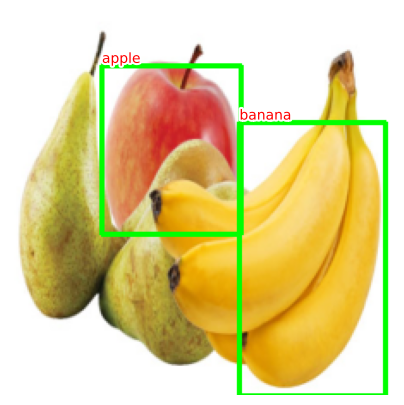

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


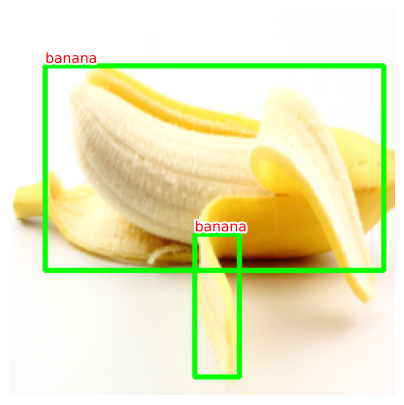

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


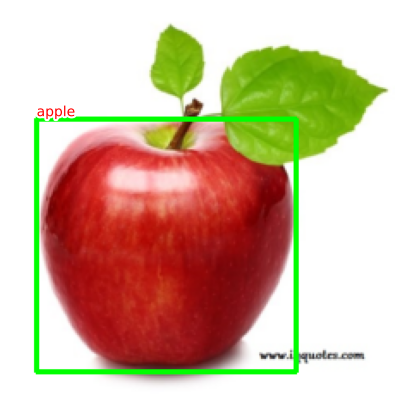

No bounding boxes detected for image 1.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


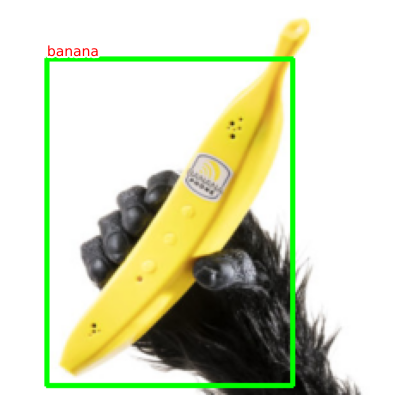

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


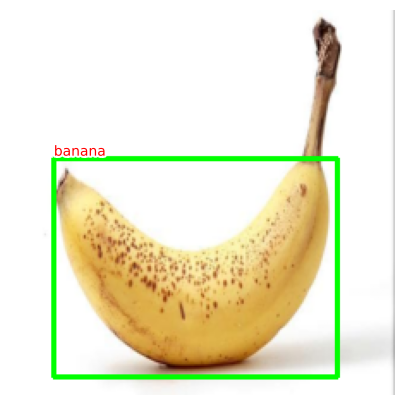

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


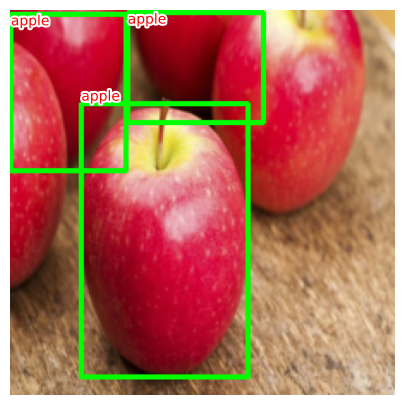

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


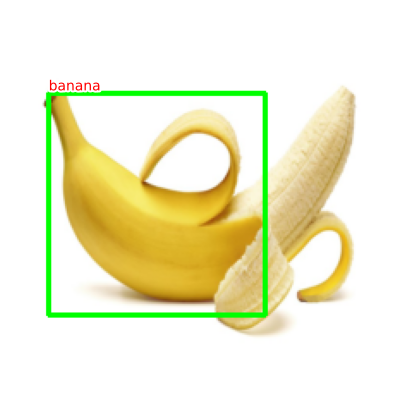

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


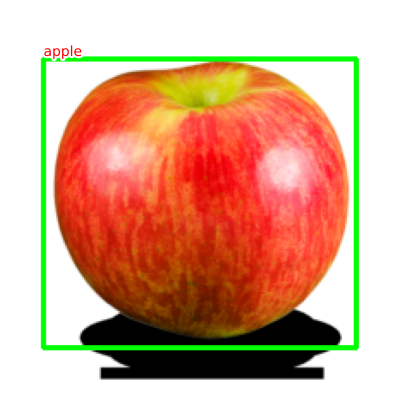

No bounding boxes detected for image 1.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


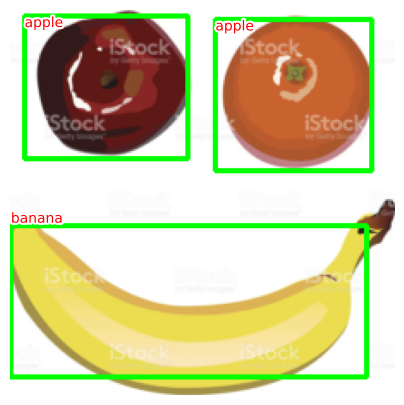

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


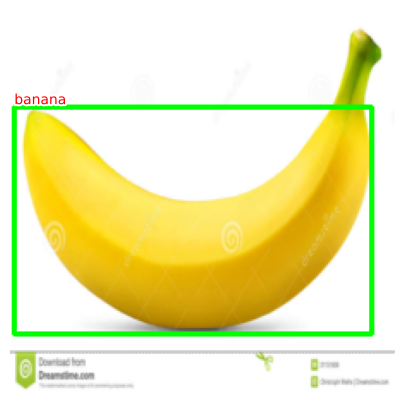

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


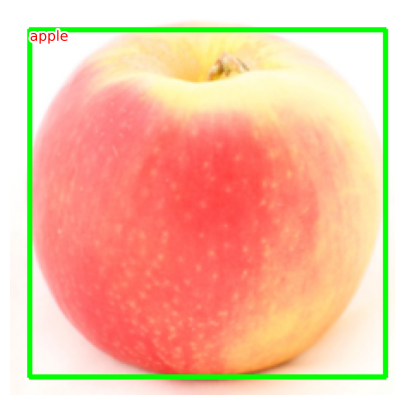

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


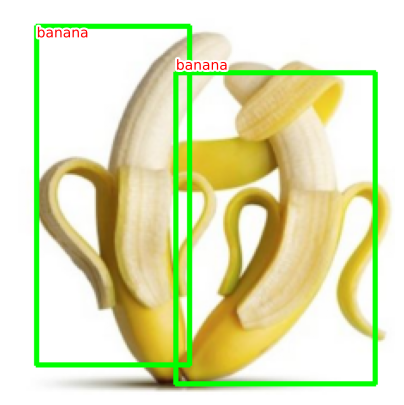

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


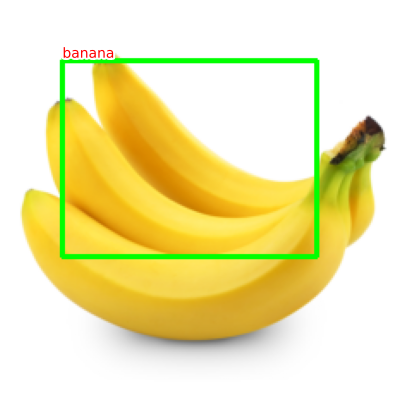

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


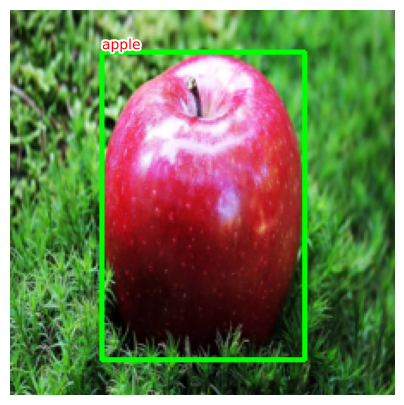

No bounding boxes detected for image 0.
No bounding boxes detected for image 1.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


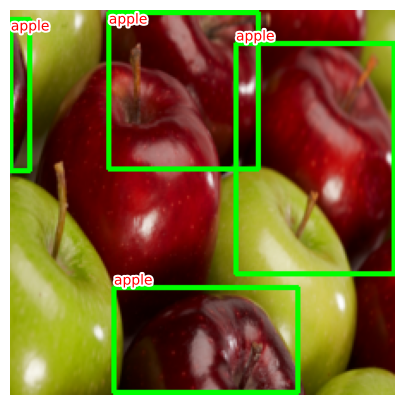

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


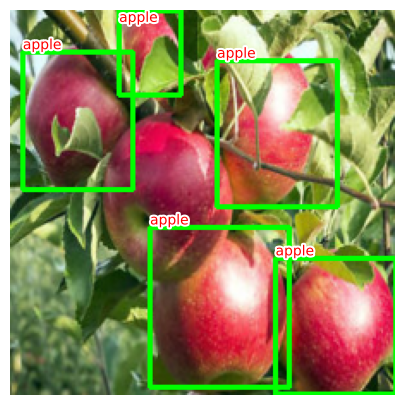

In [29]:
def decode_output(output):
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([targets2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    idxs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[idxs] for tensor in [bbs, confs, labels]]
    if len(idxs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

model.eval()

model.eval()

for i, (images, targets) in enumerate(val_dl):
    if i == 10: break
    images = [im for im in images]
    outputs = model(images)
    for i, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        if len(bbs) == 0:
            print(f"No bounding boxes detected for image {i}.")
            continue
        show(images[i].cpu().permute(1, 2, 0), bbs=bbs, texts=labels, sz=5, text_sz=10)


In [43]:
print(image_tensor.device) 
print(next(model.parameters()).device)


cpu
cpu


In [53]:
predicted_boxes = outputs[0]['boxes'].to("cpu")
predicted_labels = outputs[0]['labels'].to("cpu")
image_tensor = image_tensor.to("cpu")

In [58]:
torch.set_default_tensor_type(torch.FloatTensor)
torch.set_default_device("cpu")
torch.set_default_dtype(torch.float32)

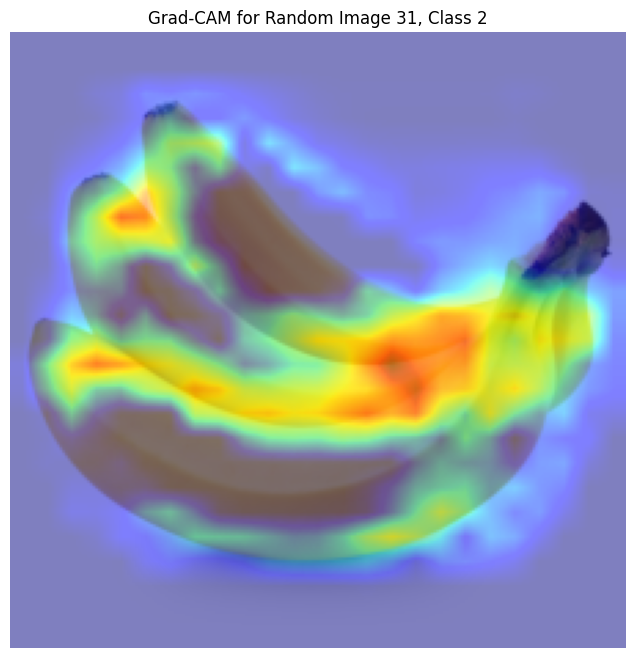

No objects detected in image 53. Skipping...


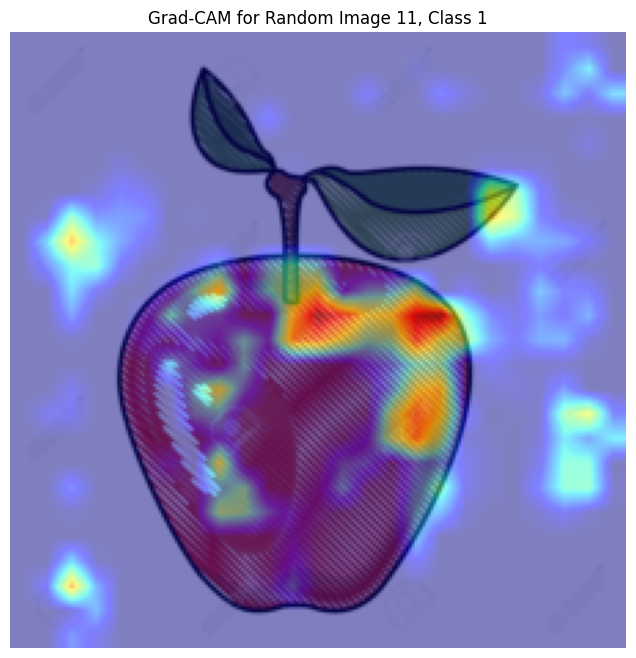

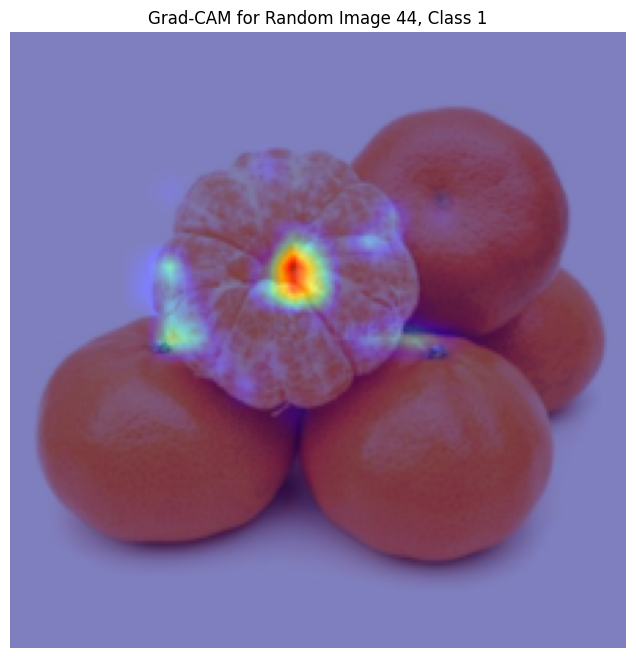

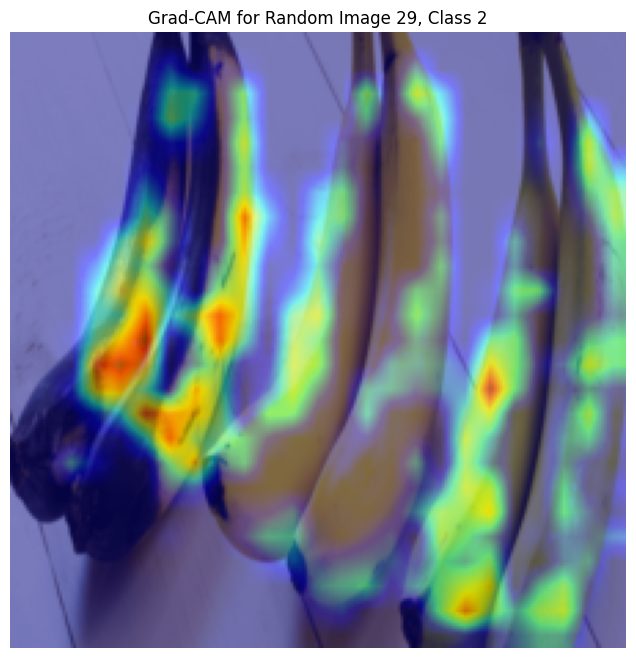

No objects detected in image 55. Skipping...


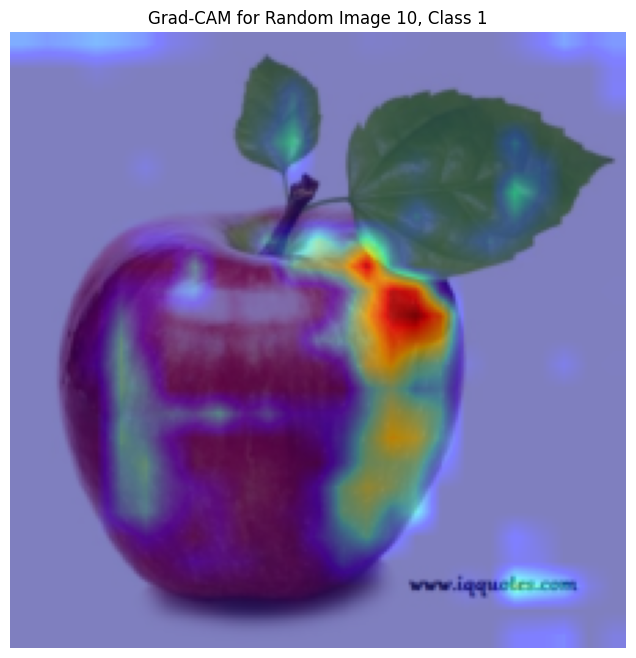

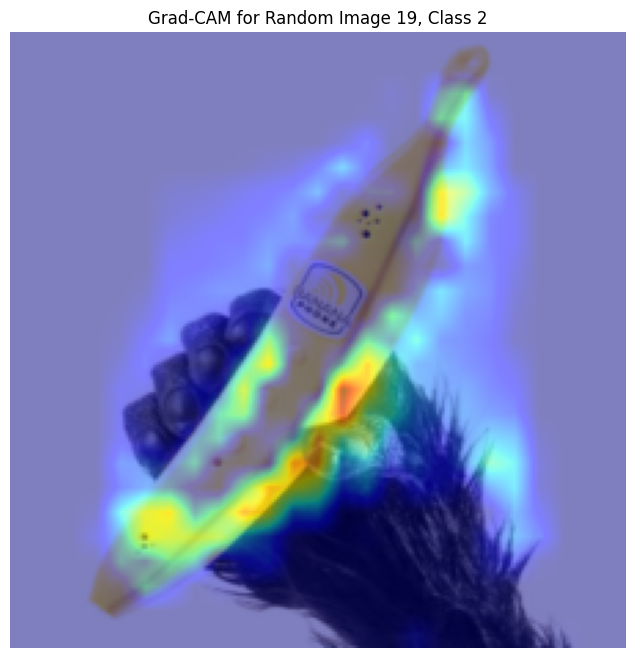

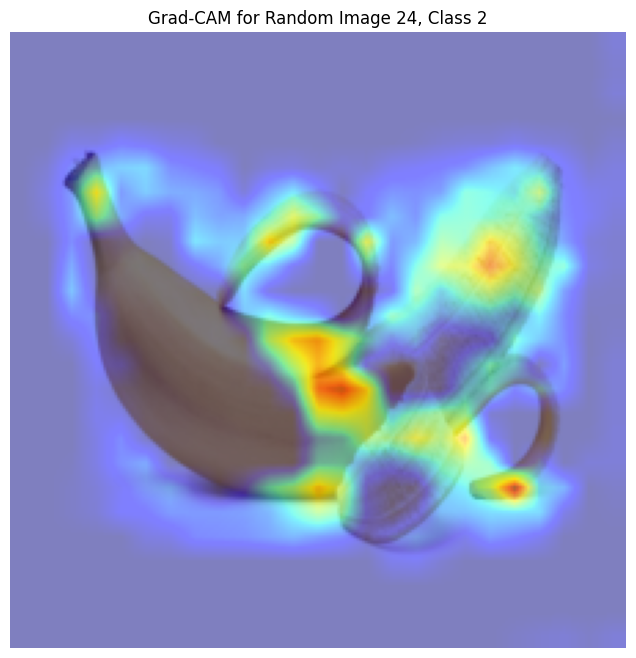

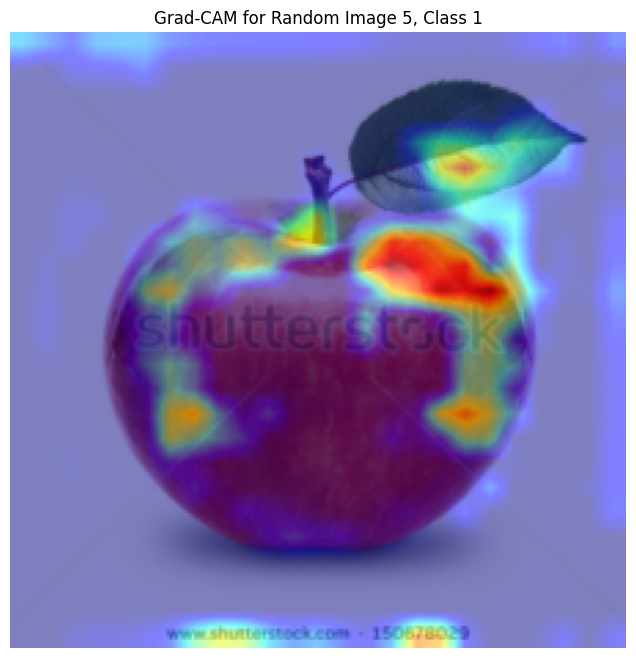

In [72]:
import os
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image
import random

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "0"
torch.backends.mps.is_available = lambda: False
torch.backends.mps.is_built = lambda: False

device = torch.device("cpu")
model.to(device)
model.eval()  

layer = model.backbone.body.layer4[-1]

def hook_store_A(module, input, output):
    module.A = output  

def hook_store_dydA(module, grad_input, grad_output):
    module.dydA = grad_output[0]  

layer.register_forward_hook(hook_store_A)
layer.register_backward_hook(hook_store_dydA)

random_indices = random.sample(range(len(val_ds)), 10)

for idx in random_indices:
    image, target = val_ds[idx]
    image_tensor = image.unsqueeze(0).to(device)

    outputs = model(image_tensor)

    if len(outputs[0]['labels']) == 0:
        print(f"No objects detected in image {idx}. Skipping...")
        continue

    class_idx = outputs[0]['labels'][0].item()
    outputs[0]['scores'][0].backward()  

    alpha = layer.dydA.mean(dim=(2, 3), keepdim=True)  
    L = torch.relu((alpha * layer.A).sum(dim=1, keepdim=True)) 
    L = F.interpolate(
        L, size=(image_tensor.size(2), image_tensor.size(3)),
        mode='bilinear', align_corners=False
    )
    L = L[0, 0].detach().cpu().numpy()  

    L = L - L.min()
    L = L / L.max()

    heatmap = cm.jet(L)[:, :, :3]
    original_image = image.permute(1, 2, 0).cpu().numpy() 
    overlay = 0.5 * original_image + 0.5 * heatmap  

    plt.figure(figsize=(8, 8))
    plt.imshow(np.clip(overlay, 0, 1)) 
    plt.axis('off')
    plt.title(f"Grad-CAM for Random Image {idx}, Class {class_idx}")
    plt.show()


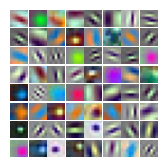

In [93]:
def visualize_filters(conv_layer, num_filters=64, figsize=(8, 8)):
    filters = conv_layer.weight.data.cpu().numpy()
    num_filters = min(num_filters, filters.shape[0]) 

    rows = int(np.sqrt(num_filters))
    cols = int(np.ceil(num_filters / rows))

    plt.figure(figsize=figsize)
    for i in range(num_filters):
        plt.subplot(rows, cols, i + 1)
        filter_image = filters[i]
        filter_image = (filter_image - filter_image.min()) / (filter_image.max() - filter_image.min())
        filter_image = np.transpose(filter_image, (1, 2, 0))  # [H, W, C]
        plt.imshow(filter_image)
        plt.axis('off')
    plt.tight_layout(pad=0.1)
    plt.show()

visualize_filters(first_conv_layer, num_filters=64, figsize=(1.5, 1.5))


Processing image: /Users/matvejzasadko/Downloads/All/Study/NNetworks/Lb1/archive/test_zip/test/apple_81.jpg
Visualizing activations for /Users/matvejzasadko/Downloads/All/Study/NNetworks/Lb1/archive/test_zip/test/apple_81.jpg


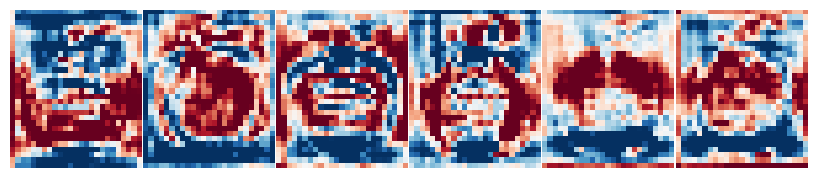

Processing image: /Users/matvejzasadko/Downloads/All/Study/NNetworks/Lb1/archive/test_zip/test/banana_89.jpg
Visualizing activations for /Users/matvejzasadko/Downloads/All/Study/NNetworks/Lb1/archive/test_zip/test/banana_89.jpg


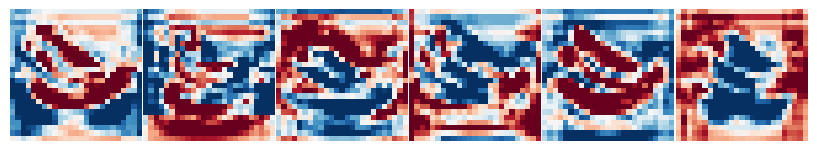

In [109]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import ToTensor
from PIL import Image

def visualize_activations(activation, num_channels=6, figsize=(8, 8), cmap="RdBu"):
    activation = activation.detach().cpu().numpy()
    channels = np.random.choice(activation.shape[0], num_channels, replace=False)

    plt.figure(figsize=figsize)
    for i, channel in enumerate(channels):
        plt.subplot(1, num_channels, i + 1)
        act_image = activation[channel]
        act_image = (act_image - act_image.mean()) / (act_image.std() + 1e-5)
        act_image = np.clip(act_image, -1, 1)
        plt.imshow(act_image, cmap=cmap)
        plt.axis("off")
    plt.tight_layout(pad=0.1)
    plt.show()

def hook_store_activation(module, input, output):
    global stored_activation
    stored_activation = output


model.eval()

target_layer = model.backbone.body.layer4[2].conv3
hook = target_layer.register_forward_hook(hook_store_activation)

def preprocess_image(image_path):
    transform = ToTensor()
    image = Image.open(image_path).convert("RGB")
    return transform(image)

image_paths = [
    "/Users/matvejzasadko/Downloads/All/Study/NNetworks/Lb1/archive/test_zip/test/apple_81.jpg",
    "/Users/matvejzasadko/Downloads/All/Study/NNetworks/Lb1/archive/test_zip/test/banana_89.jpg"
]

for image_path in image_paths:
    print(f"Processing image: {image_path}")
    image_tensor = preprocess_image(image_path).to(torch.device("cpu"))
    image_list = [image_tensor]

    _ = model(image_list)  

    print(f"Visualizing activations for {image_path}")
    visualize_activations(stored_activation[0], num_channels=6)

hook.remove()


Висновки: модель Fast R-CNN доволі таки непогані результати, як для такої маленької кількості даних Mean IoU: 0.7623
Classification Accuracy: 62.39%
На показових даних видно, що bounded box показує досить добре, і принаймні на виведених картинках фрукти були класифіковані правильно.

Подивившись на теплові карти, отриманих за допопмогою Grad-CAM можна побачити, що на деяких зображеннях увага моделі була зосереджена на не обʼєкті, а на фоні, що не є дуже добре.
